# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Import Module And Load The Data 

In [2]:
# Import all the relevant modules.
import cv2
import csv
import matplotlib.image as mpimg
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from random import randint
import seaborn as sns
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [3]:
#Load the data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as file:
    train = pickle.load(file)

with open(validation_file, mode='rb') as file:
    valid = pickle.load(file)

with open(testing_file, mode='rb') as file:
    test = pickle.load(file)

X_train_ori, y_train_ori = train['features'], train['labels']
#Create a array large enough to hold the new agumented images 
#which will be created in the pre processing section
X_train = np.empty((3*X_train_ori.shape[0],X_train_ori.shape[1],X_train_ori.shape[2],X_train_ori.shape[3]))
y_train = np.empty((3*y_train_ori.shape[0]))

X_valid, y_valid = valid['features'], valid['labels']

X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Basic Summary of the Data Set

In [4]:
#Number of original training examples
n_train_ori = X_train_ori.shape[0]
print("Number of original training examples =", n_train_ori)

# Number of training examples after image agumentation
n_train = X_train.shape[0]
print("Number of training examples =", n_train)

# Number of validation examples
n_validation = X_valid.shape[0]
print("Number of validation examples =", n_validation)

# Number of testing examples.
n_test = X_test.shape[0]
print("Number of testing examples =", n_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1:]
print("Image data shape =", image_shape)

# Unique classes/labels there are in the dataset.
n_classes = len(set(y_train_ori))
print("Number of classes =", n_classes)

Number of original training examples = 34799
Number of training examples = 104397
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


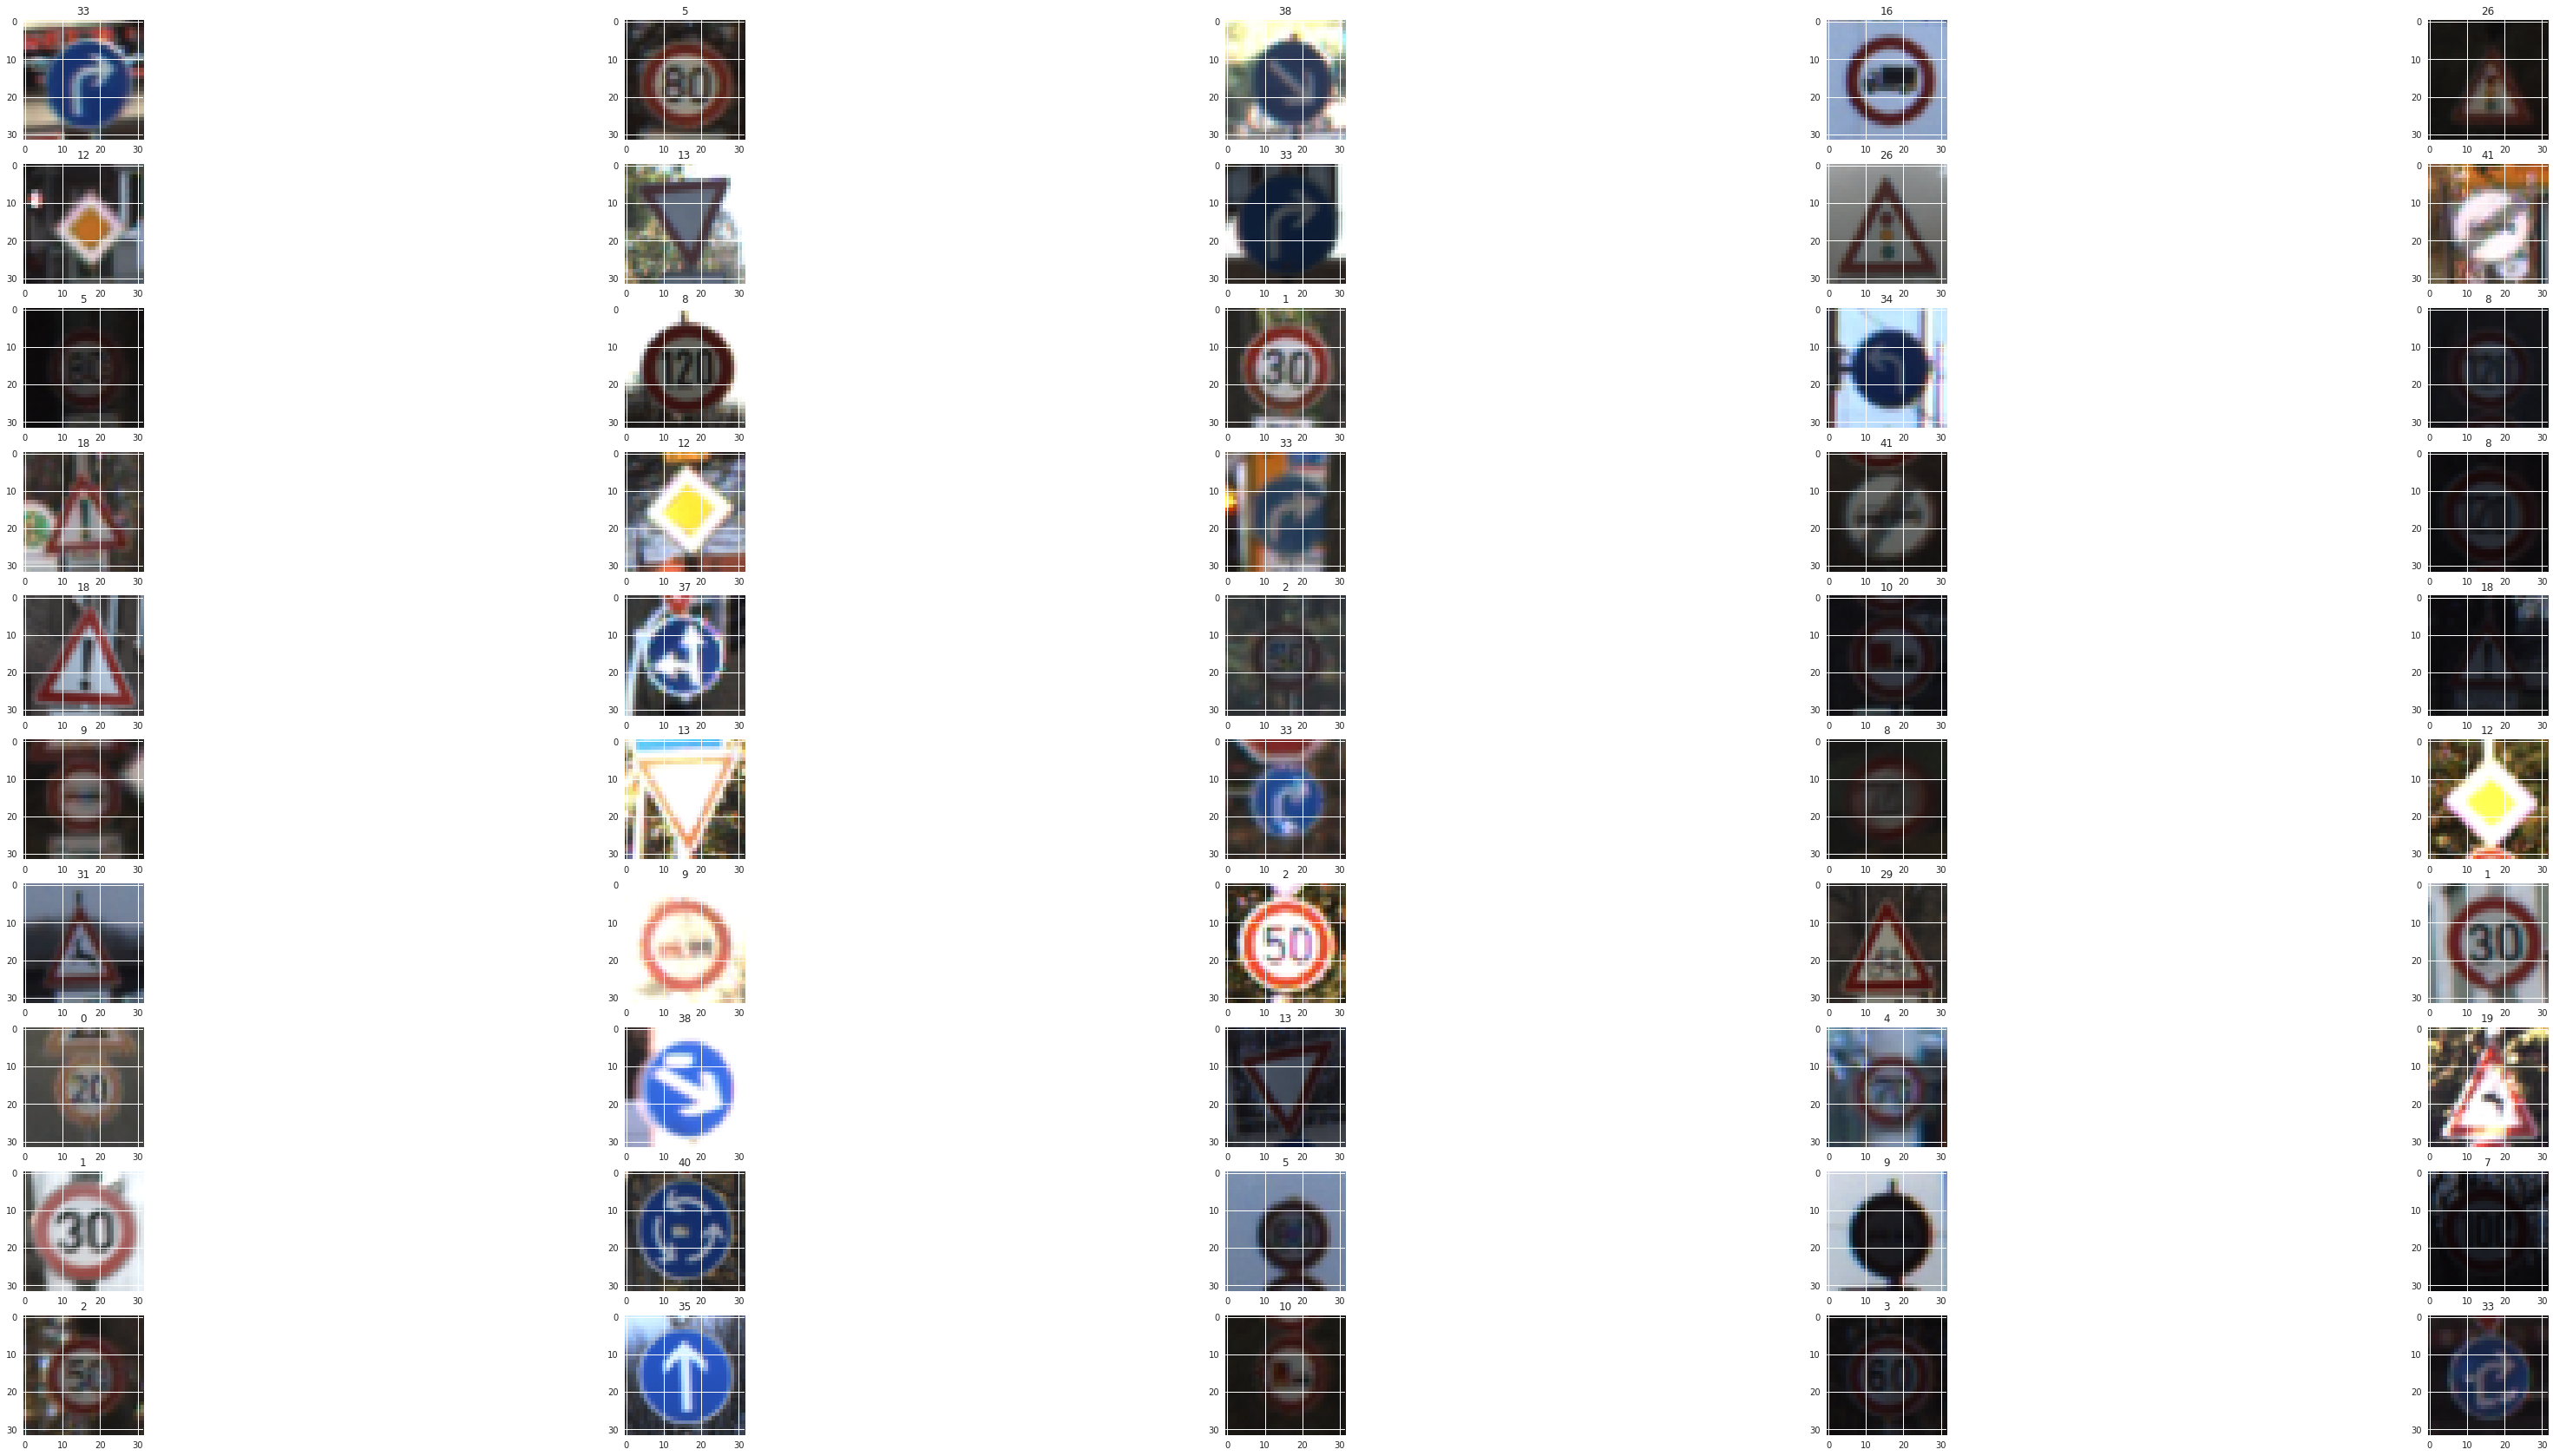

In [5]:
### Data exploration visualization
# Visualizations will be shown in the notebook.
%matplotlib inline

def plotTrafficSign(n_rows, n_cols):
    """
    This function displays random images from the trainign data set.
    """
    fig, axes  = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(60,30))
    for row in axes:
        for col in row:
            index = randint(0,n_train_ori)
            col.imshow(X_train_ori[index,:,:,:])
            col.set_title(y_train_ori[index])

#Plot traffic signs for visualization
plotTrafficSign(10, 5)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


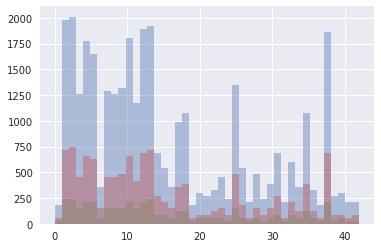

In [6]:
#Plot distribution of data
sns.distplot(y_train_ori, kde=False, bins=n_classes)
sns.distplot(y_valid, kde=False, bins=n_classes)
sns.distplot(y_test, kde=False, bins=n_classes)

Histogram of the data shows that the trainign data is unevenly distributed. This might affect the training of CNN model.
Comparing the distribution across the 3 sets (training/validation/test), it seems that the distribution is similar in all the sets.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
### Preprocess the data.

def dataGeneration():
    """
    This function auguments the training data by creating new data (via image rotation)
    """
    global X_train
    global y_train
    global y_train_ori
    global X_train_ori
    global n_train_ori
    
    #Create new data by fliping the images in the vertical and horizontal directions
    X_train[0:n_train_ori,:,:,:] = X_train_ori[:,:,:,:]
    y_train[0:n_train_ori] = y_train_ori[:]
    width = X_train.shape[1]
    height = X_train.shape[2]
    center = (width/ 2, height/ 2)
    for index in range(n_train_ori):
        #Rotate by 10 degrees
        rotation = cv2.getRotationMatrix2D(center, 10, 1.0)
        X_train[n_train_ori+index,:,:,:] = cv2.warpAffine(X_train_ori[index,:,:,:], rotation, (width, height))
        y_train[n_train_ori+index] = y_train_ori[index]
        #Flip the image horizontally
        rotation = cv2.getRotationMatrix2D(center, -10, 1.0)
        X_train[2*n_train_ori+index,:,:,:] = cv2.warpAffine(X_train_ori[index,:,:,:], rotation, (width, height))
        y_train[2*n_train_ori+index] = y_train_ori[index]

def normalize(X_input):
    """
    This function normalizes the data
    """
    #Min-Max normalization of data
    range_min = 0.1
    range_max = 0.9
    data_min = 0
    data_max = 255
    X_input = range_min + (((X_input - data_min)*(range_max - range_min) )/(data_max - data_min))
    return X_input

def randomize(X_input, y_input):
    """
    This function randomizes the data.
    """
    #Randomize the data
    X_input, y_input = shuffle(X_input, y_input)
    return X_input, y_input

dataGeneration()
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)
X_train, y_train = randomize(X_train, y_train)

### Model Architecture

In [8]:
def LeNet(x, keep_prob=1.0):  
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    global n_classes
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 300.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 300), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(300))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    #Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 300. Output = 200.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(300, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    #Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 200. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [9]:
class CModel:
    def __init__(self, input_conv, target, learning_rate = 0.001, 
                 epochs = 10, batch_size = 128, keep_prob=1.0, debug_logging = False):
        """
        This is the ctor for the class CModel.
        It initializes various hyper parameters required for training.
        """
        self.learning_rate  = learning_rate
        self.epoch = epochs
        self.batch_size = batch_size
        self.debug_logging = debug_logging
        self.input_conv = input_conv 
        self.target = target
        self.logits = None
        self.one_hot_out_class = None
        self.keep_prob = keep_prob
        
    def __loss(self):
        """
        This function calculates the loss.
        """
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_out_class, logits=self.logits)
        loss_operation = tf.reduce_mean(cross_entropy)
        return loss_operation
    
    def __optimize(self, loss_operation):
        """
        This function runs the optimizer to train the weights.
        """
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        minimize_loss = optimizer.minimize(loss_operation)
        return minimize_loss
    
    def trainLeNet(self):
        """
        This function trains the LeNet network.
        """ 
        print("n_classes ",n_classes)
        self.logits =  LeNet(self.input_conv,self.keep_prob)
        self.one_hot_out_class = tf.one_hot(self.target, n_classes)
        loss_operation = self.__loss()
        minimize_loss = self.__optimize(loss_operation)
        
        return minimize_loss
    
    def accuracy(self):
        """
        This function calculates the accuracy of the model.
        """
        prediction, _ = self.prediction()
        correct_prediction = tf.equal(prediction, tf.argmax(self.one_hot_out_class, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy_operation
    
    def prediction(self):
        return tf.argmax(self.logits, 1), tf.nn.top_k(tf.nn.softmax(self.logits), k=5)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

n_classes  43
Training...
Epoch ==  0
Validation Accuracy ==  0.828344670445
Epoch ==  1
Validation Accuracy ==  0.899999999243
Epoch ==  2
Validation Accuracy ==  0.90997732402
Epoch ==  3
Validation Accuracy ==  0.934013605712
Epoch ==  4
Validation Accuracy ==  0.940362812062
Epoch ==  5
Validation Accuracy ==  0.933106575964
Epoch ==  6
Validation Accuracy ==  0.936734694148
Epoch ==  7
Validation Accuracy ==  0.937868480726
Epoch ==  8
Validation Accuracy ==  0.943310657867
Epoch ==  9
Validation Accuracy ==  0.932879818351
Epoch ==  10
Validation Accuracy ==  0.944671202084
Epoch ==  11
Validation Accuracy ==  0.948979592107
Epoch ==  12
Validation Accuracy ==  0.949433106846
Epoch ==  13
Validation Accuracy ==  0.954875283717
Epoch ==  14
Validation Accuracy ==  0.949206349206
Epoch ==  15
Validation Accuracy ==  0.934920634677
Epoch ==  16
Validation Accuracy ==  0.955102041087
Epoch ==  17
Validation Accuracy ==  0.952380952138
Epoch ==  18
Validation Accuracy ==  0.9539682542

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


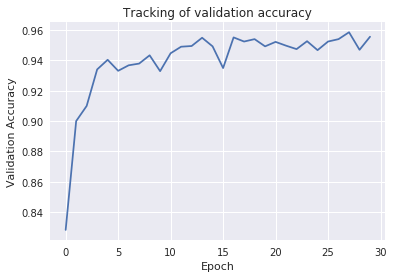

Test Accuracy =  0.937608867511


In [10]:
#Model training

class CEvaluate:
    def __init__(self, learning_rate=0.001, epoch=10, batch_size=128):
        
        self.input_conv = tf.placeholder(tf.float32, (None, 32, 32, 3))
        self.target = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)
        self.model = CModel(self.input_conv, self.target, learning_rate, epoch, batch_size, self.keep_prob)
        self.train = self.model.trainLeNet()
        self.accuracy_operation = self.model.accuracy()
        self.epoch = epoch
        self.batch_size = batch_size
        self.saver = tf.train.Saver()
        self.prediction = self.model.prediction()

    
    def __evaluate(self, X_data, y_data, keep_prob=1):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.batch_size):
            batch_x, batch_y = X_data[offset:offset+self.batch_size], y_data[offset:offset+self.batch_size]
            accuracy = sess.run(self.accuracy_operation, feed_dict={self.input_conv: batch_x, \
                                                                    self.target: batch_y, self.keep_prob: 1.0})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

    def test(self):
        global X_test
        global y_test
        with tf.Session() as sess:
            self.saver.restore(sess, tf.train.latest_checkpoint('.'))
            test_accuracy = self.__evaluate(X_test, y_test)
            print("Test Accuracy = ", test_accuracy)
    
    def predictions(self, test_images):
        with tf.Session() as sess:
            self.saver.restore(sess, './lenet')
            predict, top_k_softmax = sess.run(self.prediction, feed_dict={self.input_conv: test_images, self.keep_prob: 1.0})

            return predict, top_k_softmax

    
    def run(self):
        global X_train
        global y_train
        global X_valid
        global y_valid
        
        validation_accuracy = []
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train)
            print("Training...")
            for i in range(self.epoch):
                print("Epoch == ", i)
                for offset in range(0, num_examples, self.batch_size):
                    end = offset + self.batch_size
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    sess.run(self.train, feed_dict={self.input_conv: batch_x, self.target: batch_y, self.keep_prob: 0.9})

                validation_accuracy.append(self.__evaluate(X_valid, y_valid))
                print("Validation Accuracy == ", validation_accuracy[i])

            self.saver.save(sess, './lenet')
        
        plt.plot(validation_accuracy)
        plt.xlabel("Epoch")
        plt.ylabel("Validation Accuracy")
        plt.title("Tracking of validation accuracy")
        plt.show()

learning_rate = 0.001
epoch = 30
batch_size = 128
eval_model = CEvaluate(learning_rate, epoch, batch_size)
eval_model.run()     
eval_model.test()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


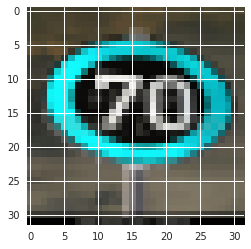

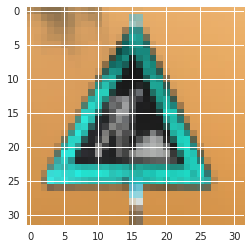

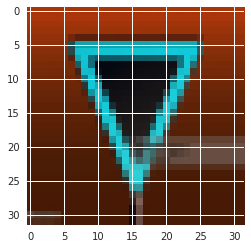

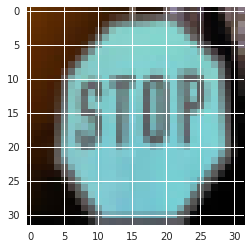

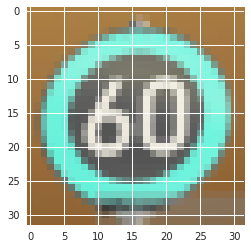

In [11]:
### Load the images and plot them.
import os
test_images = os.listdir('test_images')
num_test_images = 5
X_new_test = np.empty((num_test_images, 32, 32, 3))
y_new_test = np.empty(num_test_images)
dic = {"60.jpg":3, "70.jpg":4, "roadwork.jpg":25, "stop.jpg":14, "yield.jpg":13}
for index, image_name in enumerate(test_images):
    image_path = os.path.join('test_images', image_name)
    original_image = mpimg.imread(image_path)
    X_new_test[index,:,:,:] = cv2.resize(original_image,(32,32),interpolation=cv2.INTER_AREA)
    y_new_test[index] = dic[image_name]
    plt.imshow(X_new_test[index,:,:,:])
    plt.show()

### Predict the Sign Type for Each Image/Analyze Performance/ Output Soft Max


In [12]:
with open('signnames.csv', mode='r') as file:
    reader = csv.reader(file)
    sign_mapping = {rows[0]:rows[1] for rows in reader}

X_new_test = normalize(X_new_test)
predict, top_k_softmax = eval_model.predictions(X_new_test)

for output,expected in zip(predict,y_new_test):
    print("Expected {} ...... Output {}".format(sign_mapping[str(int(expected))], sign_mapping[str(output)]))



Expected Speed limit (70km/h) ...... Output Speed limit (20km/h)
Expected Road work ...... Output Road work
Expected Yield ...... Output Yield
Expected Stop ...... Output Stop
Expected Speed limit (60km/h) ...... Output Speed limit (60km/h)


In [13]:
### Calculate the accuracy for these 5 new images.
count = 0
for result, expectation in zip(predict, y_new_test):
    if result == expectation:
        count = count+1

accuracy = count/num_test_images
print("accuracy of the prediction of new test images", accuracy)

accuracy of the prediction of new test images 0.8


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [14]:
print("top_k_softmax == ", top_k_softmax)

top_k_softmax ==  TopKV2(values=array([[  9.57587600e-01,   3.36876549e-02,   5.43632871e-03,
          2.29410641e-03,   4.92307474e-04],
       [  1.00000000e+00,   5.26754773e-09,   1.49689350e-09,
          1.42267337e-10,   7.13285225e-13],
       [  1.00000000e+00,   4.27329814e-28,   1.11664612e-28,
          6.02633025e-31,   1.23647018e-31],
       [  1.00000000e+00,   2.56007215e-10,   6.20274179e-11,
          5.67441363e-12,   2.10394896e-12],
       [  1.00000000e+00,   1.28317490e-09,   2.37668587e-12,
          4.14809568e-15,   2.68096913e-17]], dtype=float32), indices=array([[ 0, 18, 17,  4,  8],
       [25, 29, 31, 24,  1],
       [13,  3, 12, 14,  9],
       [14,  1, 25, 29, 13],
       [ 3,  2,  1,  5, 31]], dtype=int32))


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [89]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")